# A. Conditional density estimation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from torch import nn

from matplotlib import cm
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

cwd = os.getcwd()
h, _ = os.path.split(cwd)

sys.path.append(h)

from scripts import viz, metrics

In [3]:
from datetime import datetime

MODEL_NAME = "ddpm"
DATE = datetime.today().strftime('%d.%m_%H.%M')
RESULTS_FOLDER = f"{MODEL_NAME}/{DATE}"
print(RESULTS_FOLDER)


sample_dir = os.path.join(os.getcwd(), f'{RESULTS_FOLDER}/samples')
config_dir = os.path.join(os.getcwd(), f'{RESULTS_FOLDER}/configs')
metrics_dir = os.path.join(os.getcwd(), f'{RESULTS_FOLDER}/metrics')
classifier_dir = os.path.join(os.getcwd(), f'{RESULTS_FOLDER}/classifiers')
checkpoint_dir = os.path.join(os.getcwd(), f'{RESULTS_FOLDER}/checkpoints')

for fld in [sample_dir, config_dir, metrics_dir, classifier_dir, checkpoint_dir]:
    os.makedirs(fld, exist_ok=True)

## Data

In [4]:
sb_train = pd.read_csv("../data/mock/SB_train.csv")
sb_train = shuffle(sb_train, random_state=42)

sb_valid = pd.read_csv("../data/mock/SB_val.csv")
sb_valid = shuffle(sb_valid, random_state=42)

sb_train.shape, sb_valid.shape

((500000, 6), (378876, 6))

In [5]:
X_train = sb_train[['1', '2', '3', '4']].values
C_train = sb_train[['0']].values

X_valid = sb_valid[['1', '2', '3', '4']].values
C_valid = sb_valid[['0']].values

## Fit Diffusion

In [6]:
from models import MLPBackbone
from models import ResNetBackbone

backbone_args_dict = {
    'var_dim': 4,
    'cond_dim': 1,
    'hid_dim': 256,
    'num_blocks': 8,
    'n_steps': 1000,
    'steps_dim': 256,
    'steps_depth': 4,
    'act': nn.SiLU(),
    'dropout': 0.0,
    # 'cond_include': 'sum',
    # 'cond_emb_dim': None,
    'device': 'cuda',
}

# backbone = MLPBackbone(**backbone_args_dict)
backbone = ResNetBackbone(**backbone_args_dict)

In [7]:
from models import DDPM

ddpm_args_dict = {
    'backbone': backbone,
    'betas': (1e-4, 2e-2),
    'beta_grid': 'sigmoid',
    'sigma_method': 'beta',
    'n_epochs': 100,
    'batch_size': 512,
    'checkpoint_dir': checkpoint_dir,
    'device': 'cuda',
}

wrapper = DDPM(**ddpm_args_dict)
wrapper.clear_checkpoints()
wrapper.param_summary()

Directory C:\Users\Oleg\Github\my_new_physics\notebooks\ddpm/23.05_03.40/checkpoints already exists or can not be created
Directory C:\Users\Oleg\Github\my_new_physics\notebooks\ddpm/23.05_03.40/checkpoints has been cleared!
Layer (type:depth-idx)                        Param #
DiffusionMLP                                  --
├─ResNetBackbone: 1-1                         --
│    └─SiLU: 2-1                              --
│    └─Linear: 2-2                            1,280
│    └─StepsEmbedding: 2-3                    --
│    │    └─Sequential: 3-1                   519,168
│    └─CondEmbedding: 2-4                     --
│    │    └─Sequential: 3-2                   66,304
│    └─Linear: 2-5                            2,056
│    └─ModuleList: 2-6                        --
│    │    └─ResNetBlock: 3-3                  132,096
│    │    └─ResNetBlock: 3-4                  132,096
│    │    └─ResNetBlock: 3-5                  132,096
│    │    └─ResNetBlock: 3-6                  132,096


In [8]:
from torch.optim.lr_scheduler import ExponentialLR

start_lr = 1e-5
final_lr = 1e-5
weight_decay = 0
n_epochs = ddpm_args_dict['n_epochs']
sched_lambda = (final_lr / start_lr) ** (1 / n_epochs)
print(r'Scheduler lambda:', f'{sched_lambda:.4f}')

wrapper.set_optimizer(lr=start_lr, weight_decay=weight_decay)
# wrapper.set_scheduler(ExponentialLR, gamma=sched_lambda)

Scheduler lambda: 1.0000


In [9]:
import json

full_config = {
    "ddpm": ddpm_args_dict,
    "train_args": {
        "start_lr": start_lr, 
        "weight_decay": weight_decay,
        "n_epochs": n_epochs,
        "sched_lambda": sched_lambda,
    }
}

full_config["ddpm"]["backbone"] = backbone_args_dict
full_config["ddpm"]["backbone"]["act"] = str(backbone_args_dict["act"])

with open(os.path.join(config_dir, "config.json"), "w") as outfile: 
    json.dump(full_config, outfile, indent=4)

In [10]:
from scripts.data_scaling import CATHODEScaler

gen_model_scaler = CATHODEScaler().fit(X_train, C_train)
X_train_scaled, C_train_scaled = gen_model_scaler.transform(X_train, C_train)
X_valid_scaled, C_valid_scaled = gen_model_scaler.transform(X_valid, C_valid)
X_train_scaled.shape, C_train_scaled.shape, X_valid_scaled.shape, C_valid_scaled.shape

((499927, 4), (499927, 1), (378832, 4), (378832, 1))

In [11]:
wrapper = wrapper.fit(X_train_scaled, C_train_scaled, X_valid_scaled, C_valid_scaled)

Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [49:58<00:00, 29.98s/it]


Best train loss: 0.41304
Last valid loss: 0.41594 on epoch: [41]


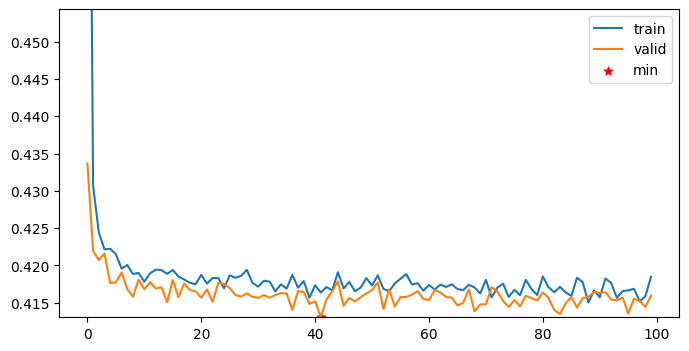

In [12]:
valid_losses = wrapper.valid_losses
min_loss = np.min(valid_losses)
last_loss = valid_losses[-1]
min_epoch = np.argmin(valid_losses).flatten()
min_loss = np.min(wrapper.valid_losses)

print(f"Best train loss: {min_loss:.5f}")
print(f"Last valid loss: {last_loss:.5f} on epoch: {min_epoch}")
plt.figure(figsize=(8, 4))
plt.plot(wrapper.train_losses, label="train")
plt.plot(valid_losses, label="valid")
plt.scatter(min_epoch, min_loss, c="r", label="min", marker="*")
plt.ylim([min_loss, min_loss * 1.1])
plt.legend()
plt.show()

In [13]:
last = len(valid_losses)
wrapper.load_from_checkpoint(last)

## Quality metrics on validation sample

In [14]:
# sample new objects
X_gen_valid_logit = wrapper.sample(C_valid, batch_size=15000)
X_gen_valid = gen_model_scaler.inverse_transform(X_gen_valid_logit)
np.save(os.path.join(sample_dir, "density_estimation.npy"), X_gen_valid)

batch: 100%|███████████████████████████████████████████████████████████████████████████| 26/26 [23:12<00:00, 53.56s/it]


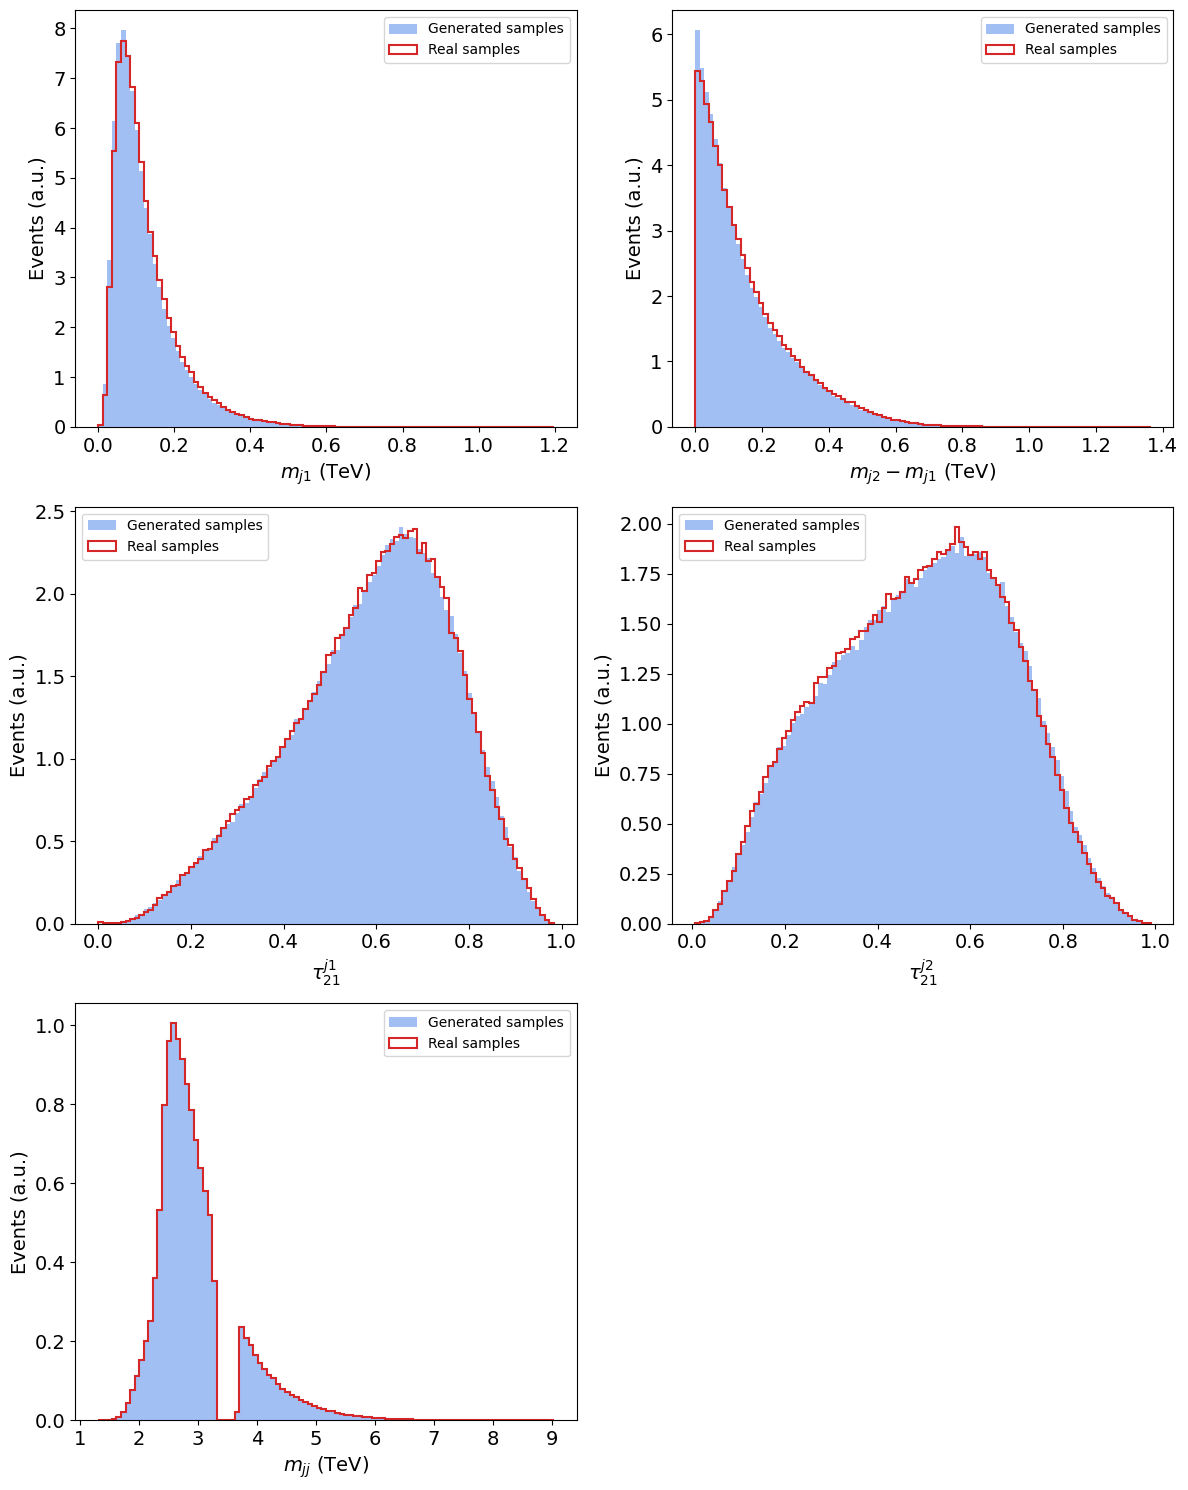

In [15]:
viz.plot_histograms(X_valid, C_valid, X_gen_valid, C_valid)

In [16]:
%%time
metrics.get_metrics(X_valid, C_valid, X_gen_valid, C_valid)

Frechet Distance         = 0.003498 +- 0.000295
Kolmogorov-Smirnov       = 0.011930 +- 0.000453
Cramer-von Mises         = 19.747312 +- 1.413757
Anderson-Darling         = 140.526496 +- 9.698361
Kullback-Leibler KDE     = 0.000216 +- 0.000023
Jensen-Shannon KDE       = 0.000056 +- 0.000003
CPU times: total: 14min 13s
Wall time: 14min 14s


**Best:**

```
Frechet Distance         = 0.000535 +- 0.000118
Kolmogorov-Smirnov       = 0.003703 +- 0.000343
Cramer-von Mises         = 0.695247 +- 0.182382
Anderson-Darling         = 5.139838 +- 1.373714
Kullback-Leibler KDE     = 0.000062 +- 0.000010
Jensen-Shannon KDE       = 0.000015 +- 0.000002
```

#  B. Interpolation and sampling

## Data

In [17]:
sr_train = pd.read_csv("../data/mock/SR_train.csv")
sr_train = shuffle(sr_train, random_state=42)

sr_valid = pd.read_csv("../data/mock/SR_val.csv")
sr_valid = shuffle(sr_valid, random_state=42)

sr_train.shape, sr_valid.shape

((60000, 6), (60000, 6))

In [18]:
# select only background events
sr_train_bkg = sr_train[sr_train['5'] == 0]
sr_valid_bkg = sr_valid[sr_valid['5'] == 0]

sr_train_bkg.shape, sr_valid_bkg.shape

((59605, 6), (59631, 6))

In [19]:
X_sr_train = sr_train[['1', '2', '3', '4']].values
C_sr_train = sr_train[['0']].values
X_sr_train_bkg = sr_train_bkg[['1', '2', '3', '4']].values
C_sr_train_bkg = sr_train_bkg[['0']].values

X_sr_valid = sr_valid[['1', '2', '3', '4']].values
C_sr_valid = sr_valid[['0']].values
X_sr_valid_bkg = sr_valid_bkg[['1', '2', '3', '4']].values
C_sr_valid_bkg = sr_valid_bkg[['0']].values

## Condition sampling with KDE

In [20]:
from sklearn.neighbors import KernelDensity

# Стандартизация не используется
# https://github.com/HEPML-AnomalyDetection/CATHODE/blob/main/data_handler.py#L683
ls_sr_cond = CATHODEScaler(use_standard=False).fit(C_sr_train)
C_sr_train_logit = ls_sr_cond.transform(C_sr_train)

kd = KernelDensity(bandwidth=0.01, kernel='gaussian').fit(C_sr_train_logit)

# N models
N = 10
cond_len = len(C_sr_valid_bkg)
# Генерируем для метрик
C_gen_sr_valid_bkg = ls_sr_cond.inverse_transform(kd.sample(cond_len))[:-(cond_len % N)]  # Чтобы было кратно
# Генерируем для семплинга X
C_sr_valid_bkg_sliced_N = C_sr_valid_bkg[:-(cond_len % N)]  # Чтобы было кратно
C_gen_sr_valid_bkg_N = ls_sr_cond.inverse_transform(kd.sample(len(C_sr_valid_bkg_sliced_N) // N))

## Background interpolation in the signal region

In [21]:
# N models
X_gen_sr_valid_bkg_N_logit = wrapper.sample_from_N_checkpoints(C_gen_sr_valid_bkg_N, N=N, batch_size=15000)
X_gen_sr_valid_bkg_N = gen_model_scaler.inverse_transform(X_gen_sr_valid_bkg_N_logit)
np.save(os.path.join(sample_dir, "interpolation.npy"), X_gen_sr_valid_bkg_N)

batch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.47s/it]


## Quality of background sampling

**Single model**

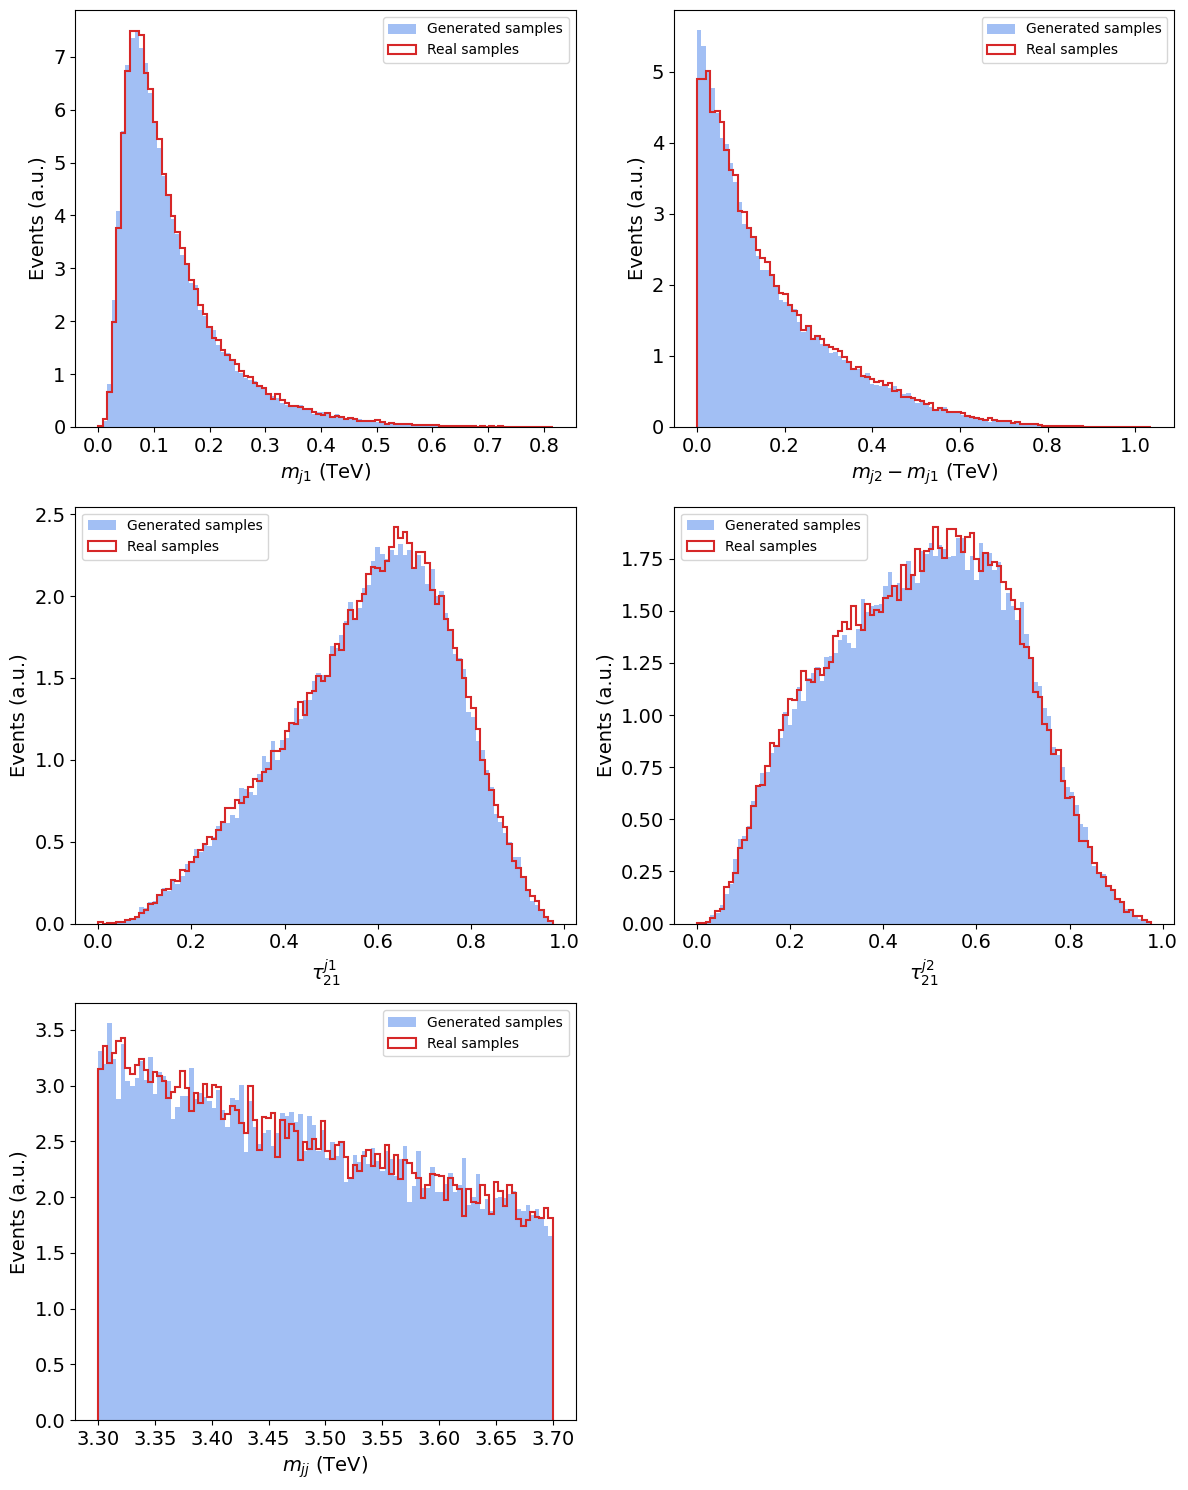

In [22]:
viz.plot_histograms(X_sr_valid_bkg, C_sr_valid_bkg, X_gen_sr_valid_bkg_N, C_gen_sr_valid_bkg)

In [23]:
%%time
metrics.get_metrics(X_sr_valid_bkg, C_sr_valid_bkg, X_gen_sr_valid_bkg_N, C_gen_sr_valid_bkg)

Frechet Distance         = 0.001555 +- 0.000443
Kolmogorov-Smirnov       = 0.010435 +- 0.001116
Cramer-von Mises         = 1.184108 +- 0.325790
Anderson-Darling         = 8.098473 +- 2.257469
Kullback-Leibler KDE     = 0.000065 +- 0.000021
Jensen-Shannon KDE       = 0.000012 +- 0.000004
CPU times: total: 1min 57s
Wall time: 1min 57s


**Best:**

```
Frechet Distance         = 0.002222 +- 0.000467
Kolmogorov-Smirnov       = 0.008405 +- 0.000877
Cramer-von Mises         = 0.544708 +- 0.169356
Anderson-Darling         = 3.407478 +- 1.219137
Kullback-Leibler KDE     = 0.000106 +- 0.000024
Jensen-Shannon KDE       = 0.000022 +- 0.000005
```

# C. Classification

## Собираем данные для классификации

Берем по 60К данных из mock и генерим 200К данных на обучение и валидацию, все в SR. Перед подачей в классификатор -- только стандартизация (логит не используется). Классы взвешиваются с учетом дисбаланса при подсчете лосса.

In [24]:
C_sr_train.min(), C_sr_train.max()

(3.3000058388954225, 3.6999854616441583)

**Генерим условие (массу)**

In [25]:
N_samples = 40000

C_sr_train_logit = ls_sr_cond.transform(C_sr_train)

kd = KernelDensity(bandwidth=0.01, kernel='gaussian').fit(C_sr_train_logit)
C_gen_sr_bkg = ls_sr_cond.inverse_transform(kd.sample(N_samples, random_state=42))
C_gen_sr_bkg.min(), C_gen_sr_bkg.max()

(3.300017618131705, 3.6999720208651743)

**Генерим данные**

In [26]:
len(C_gen_sr_bkg)

40000

In [27]:
N_models = 10

torch.cuda.empty_cache()
X_gen_sr_bkg_logit = wrapper.sample_from_N_checkpoints(C_gen_sr_bkg, N=N_models, batch_size=25000)
X_gen_sr_bkg = gen_model_scaler.inverse_transform(X_gen_sr_bkg_logit)

assert len(X_gen_sr_bkg) == N_models * N_samples
np.save(os.path.join(sample_dir, "cls_sampled_X.npy"), X_gen_sr_bkg)

batch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [02:26<00:00, 73.12s/it]


In [28]:
C_gen_sr_bkg = ls_sr_cond.inverse_transform(kd.sample(N_models * N_samples, random_state=42))
np.save(os.path.join(sample_dir, "cls_sampled_mjj.npy"), C_gen_sr_bkg)

**Присваиваем классы, создаем обучающий и валидационный наборы**

In [29]:
# mock
train_mock = sr_train.to_numpy()
valid_mock = sr_valid.to_numpy()

train_mock = np.hstack([train_mock, np.ones((train_mock.shape[0], 1))])
valid_mock = np.hstack([valid_mock, np.ones((valid_mock.shape[0], 1))])
train_mock.shape, valid_mock.shape

((60000, 7), (60000, 7))

In [30]:
X_gen_sr_bkg = np.hstack([C_gen_sr_bkg, X_gen_sr_bkg, np.zeros((N_models * N_samples, 1)), np.zeros((N_models * N_samples, 1))])
X_gen_sr_bkg.shape

(400000, 7)

**Делим синтетические данные на обучение и валидацию**

In [31]:
from sklearn.model_selection import train_test_split

train_gen, valid_gen = train_test_split(X_gen_sr_bkg, test_size=0.5, random_state=42, shuffle=True)
train_gen.shape, valid_gen.shape

((200000, 7), (200000, 7))

**Мешаем все вместе с реальными данными**

In [32]:
X_train = shuffle(np.vstack([train_gen, train_mock]), random_state=42)
X_valid = shuffle(np.vstack([valid_gen, valid_mock]), random_state=42)
X_train.shape, X_valid.shape

((260000, 7), (260000, 7))

In [33]:
m_train = X_train[:, 0]
m_valid = X_valid[:, 0]

is_sig_train = X_train[:, -2]
is_sig_valid = X_valid[:, -2]

is_real_train = X_train[:, -1]
is_real_valid = X_valid[:, -1]

data_train = X_train[:, 1:-2]
data_valid = X_valid[:, 1:-2]

## Обучение

In [34]:
BATCH_SIZE = 128
N_EPOCHS = 100
N_RUNS = 3

In [35]:
from scripts.nn_classifier import get_loaders

loaders, class_weight = get_loaders(data_train, is_real_train, data_valid, is_real_valid, batch_size=BATCH_SIZE)

class_weight: [0.65       2.16666667]


In [36]:
from scripts.nn_classifier import train_classifier

model_paths = train_classifier(loaders, class_weight, classifier_dir, n_epochs=N_EPOCHS, n_runs=N_RUNS)

Run 1...


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Run 2...


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Run 3...


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

10
Run 1 minimum validation loss epochs: [18  9 17 15 13 31 26 33 10  8]
Run 2 minimum validation loss epochs: [16 13 15  9 10 32  8  7 24 11]
Run 3 minimum validation loss epochs: [13 17 28 27 29 12 11 36  9  7]


## Предикты на тесте

In [37]:
sr_test = pd.read_csv("../data/evaluation/SR_test.csv").to_numpy()
extrabg_sr_test = pd.read_csv("../data/evaluation/extrabg_SR_test.csv").to_numpy()
X_test = np.vstack([sr_test, extrabg_sr_test])
is_sig_test = X_test[:, -1].astype(int)

# X_test_wo_mjj = X_test[:, 1:-1]
# X_test_w_mjj = X_test[:, 0:-1]

X_test.shape

(360000, 6)

In [38]:
from sklearn.preprocessing import StandardScaler
from scripts.nn_classifier import preds_from_model

sc = StandardScaler().fit(data_train)
preds_matrix = preds_from_model(X_test, sc, model_paths, save_dir=classifier_dir)
np.save(os.path.join(sample_dir, "preds_matrix.npy"), preds_matrix)
preds_matrix.shape

(3, 1, 360000)

# D. Anomaly Detection

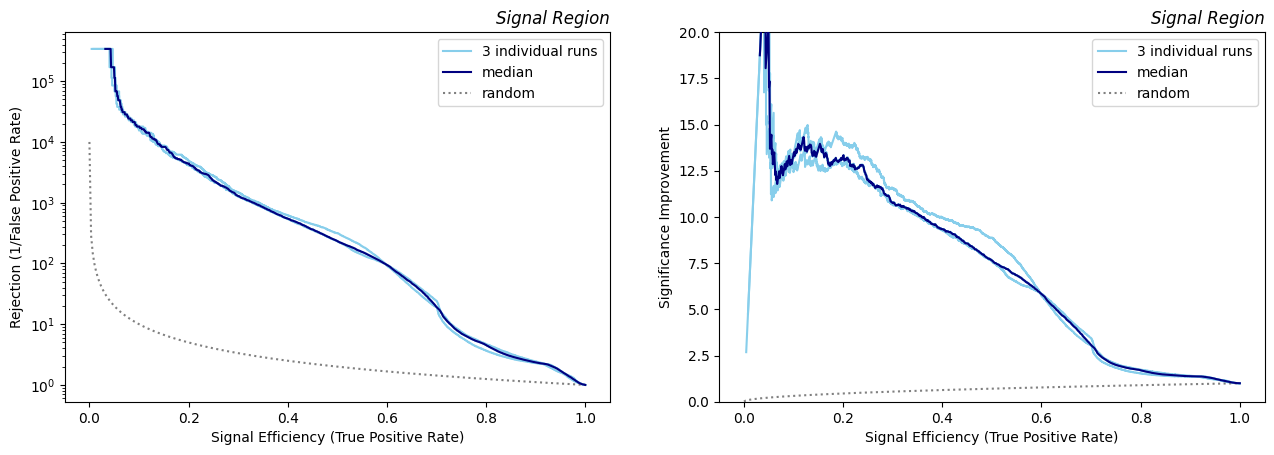

,AUC-ROC,AUC-PR,AUC-SIC
run 1,0.876611,0.671782,7.358322
run 2,0.889130,0.675810,7.286652
run 3,0.885935,0.675456,7.291764


In [39]:
from scripts.metrics import DetectionMetrics

det_metrics = DetectionMetrics()
det_metrics.show(preds_matrix, is_sig_test, save_dir=metrics_dir)